In [2]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

from dotenv import load_dotenv

load_dotenv()

llm_primary = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
llm_fallback = ChatOpenAI(model_name="gpt-4o", temperature=0)

llm = llm_primary.with_fallbacks([llm_fallback])

In [7]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import random

class GraphState(TypedDict):
    messages: List[Dict[str, Any]]
    joke: str
    error: str
    retry_count: int
    max_retries: int

def generate_joke(state):

    print("Node: generate_joke")
    messages = state['messages']
    retry_count = state.get('retry_count', 0)
    max_retries = state.get('max_retries', 3)

    try:
        if max_retries == 0:
            raise Exception("Forced error for fallback test (max_retries=0)")

        if random.random() < 0.2 and retry_count < 2:
            raise Exception("Simulated error during joke generation!")

        response = llm.invoke(messages)
        joke = response.content
        print(f"Joke generated: {joke}")
        return {"messages": messages, "joke": joke, "error": None, "retry_count": retry_count}

    except Exception as e:
        error_message = str(e)
        print(f"Error during joke generation: {error_message}")
        return {"messages": messages, "joke": None, "error": error_message, "retry_count": retry_count}


def should_retry(state):

    print("Node: should_retry")
    error = state.get("error")
    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", 3)

    if error and retry_count < max_retries:
        print(f"Error detected: '{error}'. Retrying... (Retry count: {retry_count + 1}/{max_retries})")
        return "retry"
    elif error:
        print(f"Error detected: '{error}'. Max retries reached. Proceeding to fallback.")
        return "fallback"
    else:
        print("Joke generated successfully. Continuing workflow.")
        return "continue"

def increment_retry_count(state):

    print("Node: increment_retry_count")
    retry_count = state.get("retry_count", 0)
    return {"messages": state['messages'], "joke": state.get("joke"), "error": None, "retry_count": retry_count + 1, "max_retries": state.get("max_retries", 3)} # Keep max_retries in state

def fallback_joke(state):

    print("Node: fallback_joke")
    fallback_joke_text = "Why don't scientists trust atoms? Because they make up everything!"
    print(f"Using fallback joke: {fallback_joke_text}")
    return {"messages": state['messages'], "joke": fallback_joke_text, "error": "Fallback joke used", "retry_count": state.get("retry_count", 0), "max_retries": state.get("max_retries", 3)}


def finalize_joke(state):

    print("Node: finalize_joke")
    joke = state.get("joke", "No joke could be generated.")
    error = state.get("error")

    if error and error != "Fallback joke used":
        final_message = f"Workflow completed with errors. Could not generate a joke after multiple retries. Used fallback joke: {joke}" if joke == state.get("fallback_joke_text") else f"Workflow completed with errors. Could not generate a joke after multiple retries. Fallback joke: {joke}. Error details: {error}"
    elif error == "Fallback joke used":
        final_message = f"Workflow completed using fallback joke: {joke}."
    else:
        final_message = f"Workflow completed successfully! Here's your joke: {joke}"

    print("Final Output:")
    print(final_message)
    return {"messages": state['messages'], "final_message": final_message, "joke": joke, "error": error}



workflow = StateGraph(GraphState)

workflow.add_node("generate_joke", generate_joke)
workflow.add_node("increment_retry_count", increment_retry_count)
workflow.add_node("fallback_joke", fallback_joke)
workflow.add_node("finalize_joke", finalize_joke)

workflow.set_entry_point("generate_joke")

workflow.add_conditional_edges(
    "generate_joke",
    should_retry,
    {
        "continue": "finalize_joke",
        "retry": "increment_retry_count",
        "fallback": "fallback_joke"
    }
)

workflow.add_edge("increment_retry_count", "generate_joke")
workflow.add_edge("fallback_joke", "finalize_joke")

workflow.add_edge("finalize_joke", END)

compiled_workflow = workflow.compile()


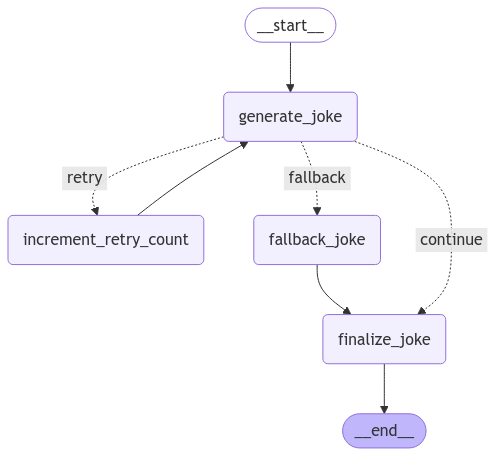

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [18]:
initial_state = {
    "messages": [{"role": "user", "content": "Tell me a short joke."}],
    "joke": None,
    "error": None,
    "retry_count": 0,
    "max_retries": 3,
}
result = compiled_workflow.invoke(initial_state)
print("\nFinal State (Run 1):", result)

Node: generate_joke
Error during joke generation: Simulated error during joke generation!
Node: should_retry
Error detected: 'Simulated error during joke generation!'. Retrying... (Retry count: 1/3)
Node: increment_retry_count
Node: generate_joke
Joke generated: Why did the scarecrow win an award? 

Because he was outstanding in his field!
Node: should_retry
Joke generated successfully. Continuing workflow.
Node: finalize_joke
Final Output:
Workflow completed successfully! Here's your joke: Why did the scarecrow win an award? 

Because he was outstanding in his field!

Final State (Run 1): {'messages': [{'role': 'user', 'content': 'Tell me a short joke.'}], 'joke': 'Why did the scarecrow win an award? \n\nBecause he was outstanding in his field!', 'error': None, 'retry_count': 1, 'max_retries': 3}


In [19]:
force_fallback_state = {
    "messages": [{"role": "user", "content": "Tell me a pun joke."}],
    "joke": None,
    "error": None,
    "retry_count": 0,
    "max_retries": 0, # Set max_retries to 0 to directly go to fallback after one attempt
}
result_fallback = compiled_workflow.invoke(force_fallback_state)
print("\nFinal State (Run 2):", result_fallback)

Node: generate_joke
Error during joke generation: Forced error for fallback test (max_retries=0)
Node: should_retry
Error detected: 'Forced error for fallback test (max_retries=0)'. Max retries reached. Proceeding to fallback.
Node: fallback_joke
Using fallback joke: Why don't scientists trust atoms? Because they make up everything!
Node: finalize_joke
Final Output:
Workflow completed using fallback joke: Why don't scientists trust atoms? Because they make up everything!.

Final State (Run 2): {'messages': [{'role': 'user', 'content': 'Tell me a pun joke.'}], 'joke': "Why don't scientists trust atoms? Because they make up everything!", 'error': 'Fallback joke used', 'retry_count': 0, 'max_retries': 0}
